<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Erin/1h35m_Copy_of_Grid_Test_European_Call_1stock_Monte_Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import cupy
# import jax
# import jax.numpy as jnp
# from jax import random
# from jax import jit
# import numpy as np
# from torch.utils.dlpack import from_dlpack

# S_range = jnp.linspace(0.75, 1.25, 10)
# K_range = jnp.linspace(0.75, 1.25, 10)
# sigma_range = jnp.linspace(0.15, 0.45, 5)
# r_range = jnp.linspace(0.01, 0.04, 3)

# print(S_range)
# print(K_range)
# print(sigma_range)
# print(r_range)

In [2]:
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
import pandas as pd
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T):
    return jnp.mean((jnp.maximum(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T)[:,-1,:], axis=1)-K,0)) * jnp.exp(-r[0] * T))

goptionvalueavg = jax.grad(optionvalueavg, argnums=1)

#################################################################### Adjust all parameters here (not inside class)
numstocks = 1
numsteps = 50
numpaths = 2000000

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)
keys = jax.random.split(key, numpaths)

S_range = jnp.linspace(0.75, 1.25, 8)
K_range = jnp.linspace(0.75, 1.25, 8)
sigma_range = jnp.linspace(0.15, 0.45, 4)
r_range = jnp.linspace(0.01, 0.04, 3)
T = 1.0

fast_simple = jax.jit(Brownian_motion, static_argnums=2)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
####################################################################

call = []

for S in S_range:
  for K in K_range:
    for r in r_range:
      for sigma in sigma_range:    

        initial_stocks = jnp.array([S]*numstocks) # must be float
        r_tmp = jnp.array([r]*numstocks)
        drift = r_tmp
        cov = jnp.identity(numstocks)*sigma*sigma

        European_Call_price = optionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, K, T)
        Deltas = goptionvalueavg(keys, initial_stocks, numsteps, drift, r_tmp, cov, K, T)
        call.append([T, K, S, sigma, r, r, European_Call_price] + list(Deltas)) #T, K, S, sigma, mu, r, price, delta

Thedataset = pd.DataFrame(call)
Thedataset

,0,1,2,3,4,5,6,7
0,1.0,0.75,0.75,0.15,0.010,0.010,0.04842615,0.556182
1,1.0,0.75,0.75,0.25,0.010,0.010,0.07799151,0.565390
2,1.0,0.75,0.75,0.35,0.010,0.010,0.107393876,0.580550
3,1.0,0.75,0.75,0.45,0.010,0.010,0.13654582,0.597454
4,1.0,0.75,0.75,0.15,0.025,0.025,0.054135688,0.595413
...,...,...,...,...,...,...,...,...
763,1.0,1.25,1.25,0.45,0.025,0.025,0.23542626,0.610198
764,1.0,1.25,1.25,0.15,0.040,0.040,0.100321844,0.633628
765,1.0,1.25,1.25,0.25,0.040,0.040,0.14790155,0.612061
766,1.0,1.25,1.25,0.35,0.040,0.040,0.19576313,0.613707


In [3]:
# save to csv
Thedataset.to_csv('European_Call_1stock_MC_Datset.csv', index=False, header=False)

In [4]:
# read csv
import pandas as pd

Thedataset = pd.read_csv('European_Call_1stock_MC_Datset.csv', header=None)
Thedataset

,0,1,2,3,4,5,6,7
0,1.0,0.75,0.75,0.15,0.010,0.010,0.048426,0.556182
1,1.0,0.75,0.75,0.25,0.010,0.010,0.077992,0.565390
2,1.0,0.75,0.75,0.35,0.010,0.010,0.107394,0.580550
3,1.0,0.75,0.75,0.45,0.010,0.010,0.136546,0.597454
4,1.0,0.75,0.75,0.15,0.025,0.025,0.054136,0.595413
...,...,...,...,...,...,...,...,...
763,1.0,1.25,1.25,0.45,0.025,0.025,0.235426,0.610198
764,1.0,1.25,1.25,0.15,0.040,0.040,0.100322,0.633628
765,1.0,1.25,1.25,0.25,0.040,0.040,0.147902,0.612061
766,1.0,1.25,1.25,0.35,0.040,0.040,0.195763,0.613707


# Construct Neural Net

In [5]:
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
import pandas as pd
from torch.utils.dlpack import from_dlpack
import torch
torch.set_printoptions(precision=6)

Thedataset_X = Thedataset.iloc[:,:6]
Thedataset_Y = Thedataset.iloc[:,6:]

class OptionDataSet(object):
    
    def __init__(self, max_len):
        self.num = 0
        self.max_length = max_len
        self.X = cupy.array(Thedataset_X)
        self.Y = cupy.array(Thedataset_Y)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num >= self.max_length:
            raise StopIteration

        self.num += 1
        return (from_dlpack(self.X.toDlpack()), from_dlpack(self.Y.toDlpack()))

# # print
# ds = OptionDataSet(max_len = 1)
# for i in ds:
#     print(i[0])
#     print(i[0].shape)
#     print(i[1])
#     print(i[1].shape)

In [6]:
%%writefile model.py
# version 1,2
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6*1, 32) # remember to change this!
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1) # 1 outputs: price
        self.register_buffer('norm',
                             torch.tensor([1.0, 0.5, 0.5, 0.3, 0.03, 0.03]*1)) # don't use numpy here - will give error later
                                                                               # T, K, S, sigma, mu, r

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = (x - torch.tensor([0.0, 0.75, 0.75, 0.15, 0.01, 0.01]*1).cuda()) / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Overwriting model.py


# Train Neural Net

In [7]:
!pip install pytorch-ignite

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# version 2, 7
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 100) # Use max_len to adjust

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    # print(x)
    # print(x.shape)
    y = batch[1]
    # print(y)
    # print(y.shape)
    y_pred = model(x.float())
    # print(y_pred)
    # print(y_pred.shape)

    def compute_deltas(x):
      inputs = x.float()
      inputs.requires_grad = True
      first_order_gradient = grad(model(inputs), inputs, create_graph=False)
      return first_order_gradient[0][[2]]

    deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    y_pred = torch.cat((y_pred, deltas), 1)
    # print(y_pred)
    # print(y_pred.shape)

    loss_weight = torch.tensor([1, 1]).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 100)

model_save_name = 'jax_european_1stock_MC_oneDS_1.pth'
path = F"/content/drive/MyDrive/AFP/Save_Models/{model_save_name}" 
torch.save(model.state_dict(), path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: /usr/local/lib/python3.7/dist-packages/ignite/contrib/handlers/param_scheduler.py has been moved to /ignite/handlers/param_scheduler.py and will be removed in version 0.6.0.
 Please refer to the documentation for more details.
  if __name__ == '__main__':


loss 0.17811144974877263 average time 1.1001368254999988 iter num 20
loss 0.152724189425745 average time 1.0964266145499892 iter num 40
loss 0.13121183970156705 average time 1.099168872599993 iter num 60
loss 0.1203134165838254 average time 1.0966257145624951 iter num 80
loss 0.1179064114321857 average time 1.0973092113099916 iter num 100
loss 0.07163074874668786 average time 1.101716471349971 iter num 20
loss 0.04290047739052574 average time 1.0976058901249757 iter num 40
loss 0.03743324633630384 average time 1.0966254368999975 iter num 60
loss 0.036930155043607533 average time 1.0952950840749935 iter num 80
loss 0.03687383433663143 average time 1.095878112219998 iter num 100
loss 0.03615459411613244 average time 1.091649145399981 iter num 20
loss 0.035540813249455086 average time 1.0908864717999962 iter num 40
loss 0.03512925857709737 average time 1.0912184368666695 iter num 60
loss 0.03494170213618804 average time 1.092458604887503 iter num 80
loss 0.034901684377374544 average time 

ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

In [ ]:
#1h5m

**Save Model**

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import torch
model_save_name = 'jax_european_1stock_MC_oneDS_1.pth'
path = F"/content/drive/MyDrive/AFP/Save_Models/{model_save_name}" 
torch.save(model.state_dict(), path)

**Load Model**

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import torch
model_save_name = 'jax_european_1stock_MC_oneDS_1.pth'
path = F"/content/drive/MyDrive/AFP/Save_Models/{model_save_name}" 
state_dict = torch.load(path)
print(state_dict.keys())

odict_keys(['norm', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias', 'fc6.weight', 'fc6.bias'])


In [25]:
# need to run 'Writing cupy_dataset.py' and 'Writing model.py' above before this
from model import Net
model = Net().cuda()

model.load_state_dict(state_dict)
print(model)

Net(
  (fc1): Linear(in_features=6, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=1, bias=True)
)


**Continue to train model**

In [22]:
# version 2, 7
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
#model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 100) # Use max_len to adjust

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x.float())

    def compute_deltas(x):
      inputs = x.float()
      inputs.requires_grad = True
      first_order_gradient = grad(model(inputs), inputs, create_graph=False)
      return first_order_gradient[0][[2]]

    deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    y_pred = torch.cat((y_pred, deltas), 1)

    loss_weight = torch.tensor([1, 1]).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 100)

model_save_name = 'jax_european_1stock_MC_oneDS_1.pth'
path = F"/content/drive/MyDrive/AFP/Save_Models/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 0.00044160535377733634 average time 1.121685523899896 iter num 20
loss 0.0004355566696387979 average time 1.1184198466499538 iter num 40
loss 0.0004380600842337669 average time 1.1148865964166512 iter num 60
loss 0.00043581948394787016 average time 1.1149899558249785 iter num 80
loss 0.0004352953693053974 average time 1.1145535318899693 iter num 100
loss 0.00043107159031029787 average time 1.1050351419499294 iter num 20
loss 0.00042772246643635575 average time 1.1076630771249711 iter num 40
loss 0.0004251425714338885 average time 1.1094189081666779 iter num 60
loss 0.0004239944030110841 average time 1.1097618952500057 iter num 80
loss 0.0004237335807839413 average time 1.1095641925699875 iter num 100
loss 0.000418773862537455 average time 1.1051849061000667 iter num 20
loss 0.00041435743092075927 average time 1.109574453100049 iter num 40
loss 0.00041143013507278 average time 1.1081407281666542 iter num 60
loss 0.00041008542957232864 average time 1.1102389049124781 iter num 80
los

ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

In [ ]:
# 1h35m

#Results

In [26]:
import torch
inputs = torch.tensor([[1, 1, 1, 0.25, 0.02, 0.02]]).cuda() # T, K, S, sigma, mu, r
print('price: ' + str(model(inputs.float())))

inputs.requires_grad = True
x = model(inputs.float())
x.backward()
first_order_gradient = inputs.grad
first_order_gradient[0][[2]]

# price, delta
# should be around (0.10870558, 0.581213937)

price: tensor([[0.108900]], device='cuda:0', grad_fn=<AddmmBackward0>)


tensor([0.599002], device='cuda:0')

In [27]:
import cupy
import numpy as np
from torch.utils.dlpack import from_dlpack
from scipy.stats import norm
from math import log, sqrt, pi, exp
import pandas as pd

def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)    
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))
def bs_delta(S,K,T,r,sigma):
    return norm.cdf(d1(S,K,T,r,sigma))

print(bs_call(1,1,1,0.02,0.25))
print(bs_delta(1,1,1,0.02,0.25))

0.10870558490557591
0.5812139374874482


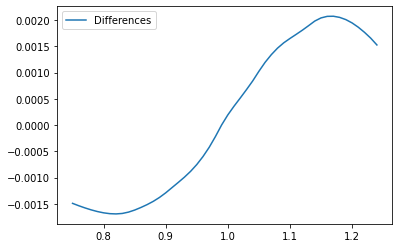

In [28]:
from scipy.stats import norm
from math import log, sqrt, pi, exp
import matplotlib.pyplot as plt
import numpy as np

def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)    
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))

def compute_price(S):
    inputs = torch.tensor([[1, 1, S, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())

prices = np.arange(0.75, 1.25, 0.01)
model_call_prices = []
BS_call_prices = []
for p in prices:
    model_call_prices.append(compute_price(p).item())
    BS_call_prices.append(bs_call(p, 1, 1, 0.02, 0.25))

#plt.plot(prices, model_call_prices, label = "model_call_prices")
#plt.plot(prices, BS_call_prices, label = "BS_call_prices")
plt.plot(prices, np.array(model_call_prices)-np.array(BS_call_prices), label = "Differences")
plt.legend()
plt.show()

# Delta

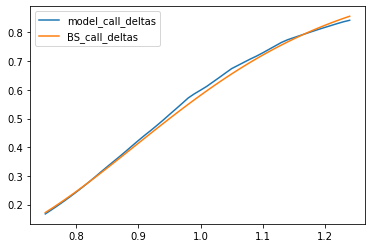

In [29]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 1, S, 0.25, 0.02, 0.02]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]

def bs_delta(S,K,T,r,sigma):
  return norm.cdf(d1(S,K,T,r,sigma))

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
BS_call_deltas = []
for p in prices:
    model_call_deltas.append(compute_delta(p).item())
    BS_call_deltas.append(bs_delta(p, 1, 1, 0.02, 0.25))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, BS_call_deltas, label = "BS_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(BS_call_deltas), label = "Differences")
plt.legend()
plt.show()

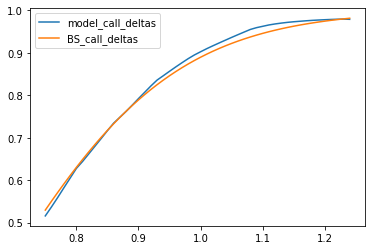

In [30]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 0.775, S, 0.25, 0.02, 0.02]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]

def bs_delta(S,K,T,r,sigma):
  return norm.cdf(d1(S,K,T,r,sigma))

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
BS_call_deltas = []
for p in prices:
    model_call_deltas.append(compute_delta(p).item())
    BS_call_deltas.append(bs_delta(p, 0.775, 1, 0.02, 0.25))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, BS_call_deltas, label = "BS_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(BS_call_deltas), label = "Differences")
plt.legend()
plt.show()

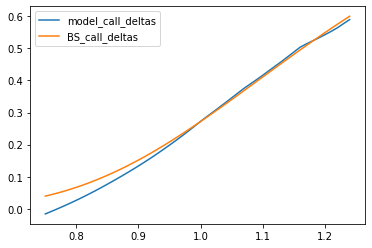

In [31]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 1.225, S, 0.25, 0.02, 0.02]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]

def bs_delta(S,K,T,r,sigma):
  return norm.cdf(d1(S,K,T,r,sigma))

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
BS_call_deltas = []
for p in prices:
    model_call_deltas.append(compute_delta(p).item())
    BS_call_deltas.append(bs_delta(p, 1.225, 1, 0.02, 0.25))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, BS_call_deltas, label = "BS_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(BS_call_deltas), label = "Differences")
plt.legend()
plt.show()